## Costruzione del dataset di apprendimento

In [1]:
from traceback import print_tb
import networkx as nx
import csv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time

#credenziali per usare le api di spotipy
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id="85aa8b30835e45a3b99623b2797df916",client_secret="ecb8aa6ad9d7431db74fb99af51dec93"))

#il file global.csv contiene i link delle classifiche top 50 di ogni paese interessato, oltre al link dela classifica top 50 global
people = list()
with open('global.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        people.append(row)

#elimino la voce corrispondente al link della playlist top 50 global
del people[0]
dataset = list()

j = 0
aux = {}
pausa = 0
pausaPaese = 0

#siccome spotify banna per 24 ore se si fanno troppe richieste in poco tempo, mi fermo per 35 secondi ogni 8 paesi considerati e, per ogni paese, mi fermo per 35 secondi ogni 8 canzoni considerate
for s in range(0,73):
    pausaPaese += 1
    if pausaPaese % 8 == 0:
        time.sleep(35)
    #per capire se sono passato al prossimo paese, questa e un'altra print mi sono utili per capire se sono stato bannato oppure no, perchè altrimenti inizia a stampare "Max Retries Reached" e non posso usare le api per 24 ore
    print('prossimo paese')
    #ricavo la playlist top 50 del paese interessato
    playlist = spotify.playlist(people[s]["Link"])
    #e ne prendo tutte le canzoni
    songs = spotify.playlist_items(playlist["id"]) 
    #considero le prime 25 canzoni (ho avuto problemi di ban anche fermandomi ogni 35 secondi, ho stabilito che 25 canzoni per paese era il numero massimo di richieste che potevo fare)
    for i in range (0,26):
        pausa += 1
        if pausa % 8 == 0:
            time.sleep(35)
        #per capire se sto scorrendo le canzoni
        print('dentro al ciclo')
        #ricavo isrc, uri della canzone e degli artisti e i generi degli artisti
        isrc = songs["items"][i]["track"]["external_ids"]["isrc"]
        track_uri = songs["items"][i]["track"]["uri"]
        artist_uri = songs["items"][i]["track"]["artists"][0]["uri"]
        genres = spotify.artist(artist_uri)["genres"]
        info = spotify.audio_features(track_uri)[0]
        
        #prelevo la danceability della canzone
        danceability = 0
        try:
            danceability = info['danceability']
        except:
            pass

        #prelevo l'energy della canzone
        energy = 0
        try:
            energy = info['energy']
        except:
            pass

        #prelevo la speechiness della canzone
        speechiness = 0
        try:
            speechiness = info['speechiness']
        except:
            pass

        #prelevo l'acousticness della canzone
        acousticness = 0
        try:
            acousticness = info['acousticness']
        except:
            pass

        #prelevo l'instrumentalness della canzone
        instrumentalness = 0
        try:
            instrumentalness = info['instrumentalness']
        except:
            pass
        
        #prelevo la valence della canzone
        valence = 0
        try:
            valence = info['valence']
        except:
            pass

        #prelevo il tempo in bpm della canzone
        tempo = 0
        try:
            tempo = info['tempo']
        except:
            pass

        #salvo queste informazioni in aux
        aux[j] = {"paese": people[s]["Name"],"isrc":isrc,"uri":track_uri,"genres":genres,"danceability":danceability,"energy":energy,"speechiness":speechiness,"acousticness":acousticness,"instrumentalness":instrumentalness,"valence":valence,"tempo":tempo}
        j = j+1
pausaPaese = 0
print('uscito dal ciclo')
print(aux)

#infine, scrivo il tutto in un file csv
with open('machine-global01.csv', 'w+', newline='') as file:
    writer = csv.DictWriter(file,fieldnames=["paese","isrc","uri","genres","danceability","energy","speechiness","acousticness","instrumentalness","valence","tempo"])
    writer.writeheader()
    for i in range (j) :
        print('scrivo il file')
        writer.writerow(aux[i])

prossimo paese
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
prossimo paese
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo
dentro al ciclo


## Visualizzazione dei box plot degli attributi del dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

data = pd.read_csv('machine-global-mergedfix2 - Copia.csv', sep = ',')

'''
outlier di sinistra: valori < 1quartile-(1.5*rangeinterquartile)
outlier di destra: valori > 3quartile+(1.5*rangeinterquartile)
'''

data['danceability'].plot.box(vert = False)
plt.show()
#outlier di sinistra: valori che sono < 1°quartile-(1.5*rangeinterquartile)
sxOutliers = data['danceability'].quantile(0.25)-(1.5*(data['danceability'].quantile(0.75)-data['danceability'].quantile(0.25)))
#outlier di destra: valori che sono > 3°quartile+(1.5*rangeinterquartile)
dxOutliers = data['danceability'].quantile(0.75)+(1.5*(data['danceability'].quantile(0.75)-data['danceability'].quantile(0.25)))
print(f'valori totali:{len(data.danceability)}\noutlier:{len(data[data.danceability < sxOutliers])+len(data[data.danceability > dxOutliers])}\nvalori nulli:{len(data[data.danceability.isna()])}')


## Applicazione della regressione logistica

C:\Users\cola0\AppData\Local\Temp\ipykernel_13512\2154769238.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset_link_prediction[genere] = 0
C:\Users\cola0\AppData\Local\Temp\ipykernel_13512\2154769238.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset_link_prediction[genere] = 0
C:\Users\cola0\AppData\Local\Temp\ipykernel_13512\2154769238.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

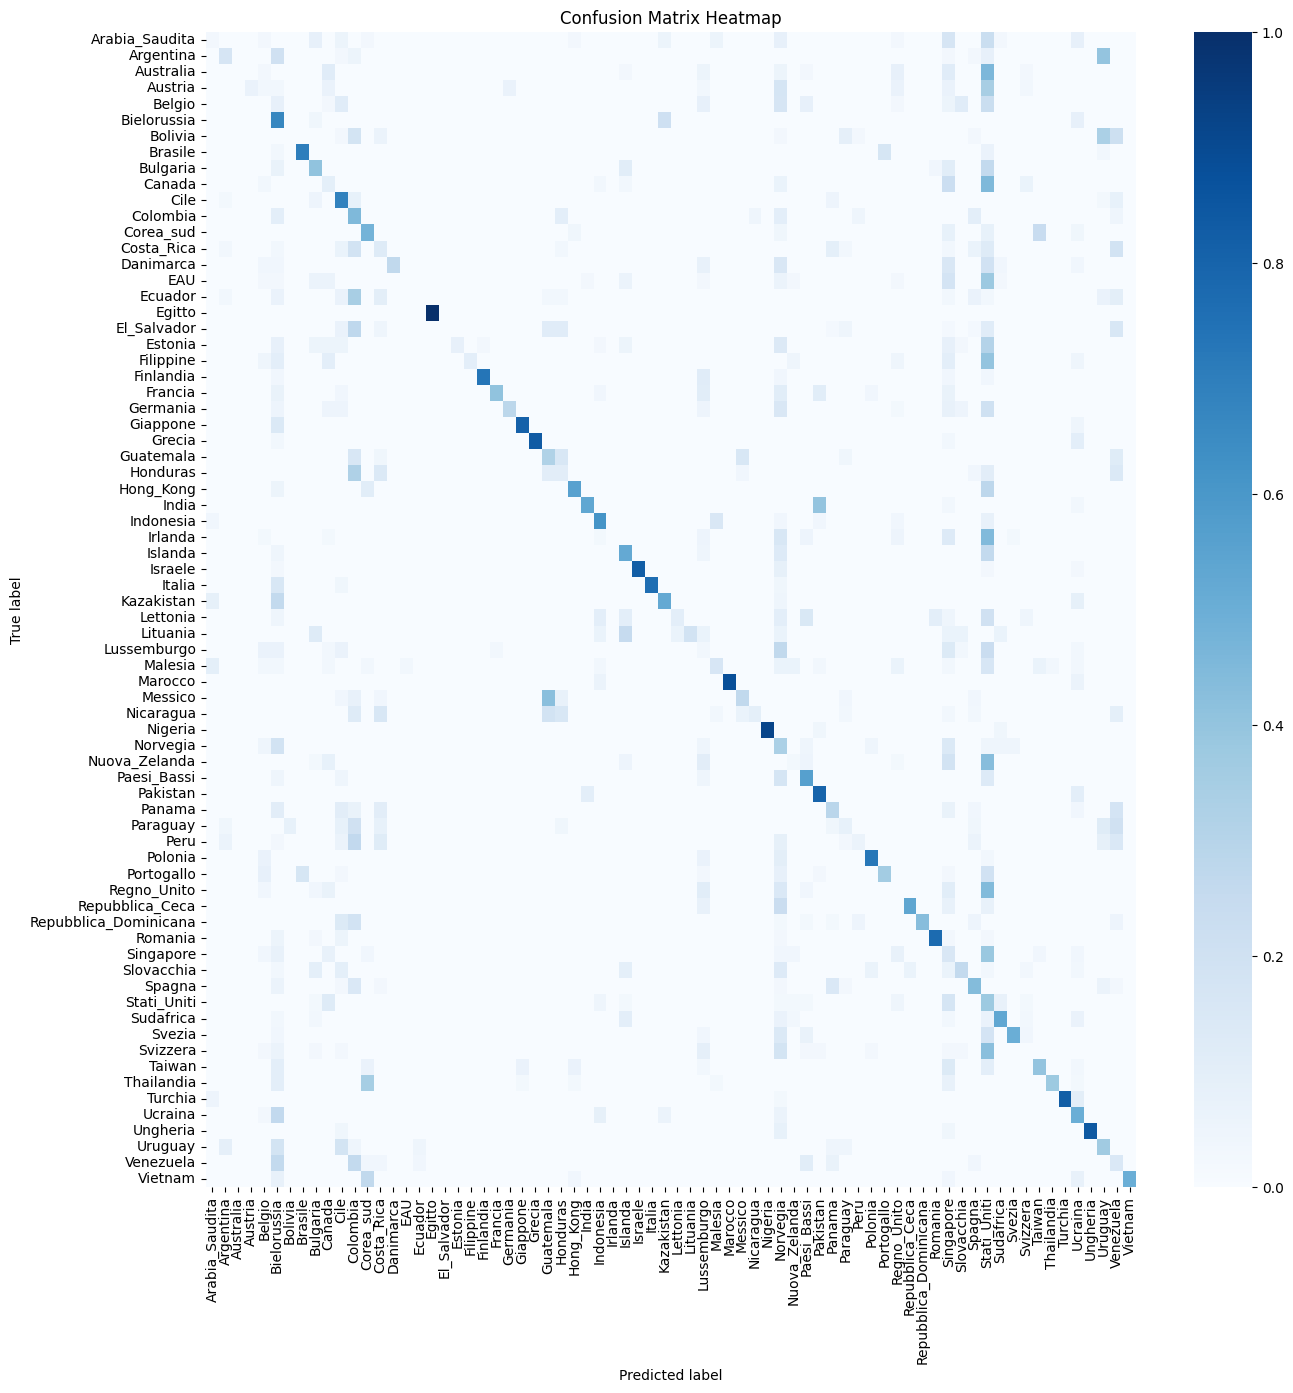

0.35877862595419846


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Carica il dataset
dataset_link_prediction = pd.read_csv('machine-global-mergedfix2 - Copia.csv')

# Estrai i generi unici
generi = set()
with open('machine-global-mergedfix2 - Copia.csv', 'r') as f:
    csv_reader = csv.reader(f)
    for line in csv_reader:
        s = line[3].replace("[", "").replace("]", "").replace("'", "")
        genres = s.split(",")
        for genre in genres:
            if len(genre) > 0 and genre[0] == " ":
                genre = genre[1:]
            generi.add(genre)

# Aggiungi colonne di genere al dataset
for genere in generi:
    dataset_link_prediction[genere] = 0

# Riempi le colonne di genere con valori binari
riga = -1
with open('machine-global-mergedfix2 - Copia.csv', 'r') as f:
    csv_reader = csv.reader(f)
    for line in csv_reader:
        if line[0] != 'paese':
            riga += 1
            s = line[3].replace("[", "").replace("]", "").replace("'", "")
            genres = s.split(",")
            for genre in genres:
                if len(genre) > 0 and genre[0] == " ":
                    genre = genre[1:]
                dataset_link_prediction.loc[riga, genre] = 1

# Matrice delle caratteristiche e vettore delle etichette
X = dataset_link_prediction.iloc[:, 4:]
y = dataset_link_prediction['paese']

# Divisione train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)

# Modello di regressione logistica
clf_logreg = LogisticRegression()
clf_logreg.fit(X_train_minmax, y_train)
X_test_minmax = min_max_scaler.transform(X_test)
y_predicted_lr = clf_logreg.predict(X_test_minmax)

# Matrice di confusione
cm = confusion_matrix(y_test, y_predicted_lr, normalize='true')

# Visualizzazione della heatmap
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(cm,  fmt='.2f', cmap='Blues', xticklabels=clf_logreg.classes_, yticklabels=clf_logreg.classes_, ax=ax)
plt.xticks(rotation=90)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Report di classificazione
classification_rep = classification_report(y_test, y_predicted_lr)
# Accuracy score
accuracy = accuracy_score(y_test, y_predicted_lr)

print(accuracy)
#classification_rep, accuracy
